# 0.0 IMPORTS

In [1]:
import math
import numpy    as np
import pandas   as pd
import inflection
import seaborn  as sns
import matplotlib.pyplot as plt

from IPython.display import Image
import datetime
from matplotlib.gridspec import GridSpec



## 0.1 Helper Functions

In [2]:
pd.set_option('display.max_columns', None)

## 0.2 Loadind Data

In [3]:
df_sales_raw = pd.read_csv( 'data/train.csv', low_memory=False )
df_store_raw = pd.read_csv( 'data/store.csv', low_memory=False )

# merge
df_raw = pd.merge( df_sales_raw, df_store_raw, how='left', on='Store' )

# 1.0. PASSO 01 - DESCRIÇÃO DOS DADOS

In [4]:
df1 = df_raw.copy()

## 1.1. Rename Columns

In [5]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore( x )

cols_new = list( map( snakecase, cols_old ) )

# rename
df1.columns = cols_new

## 1.2. Data Dimensions

In [6]:
print( 'Number of Rows:{}'.format( df1.shape[0] ) )
print( 'Number of Cols:{}'.format( df1.shape[1] ) )

Number of Rows:1017209
Number of Cols:18


## 1.3. Data Types

In [7]:
df1['date'] = pd.to_datetime( df1['date'] )
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4. Check NA

In [8]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5. Fillout NA

In [9]:
#competition_distance
df1['competition_distance'] = df1['competition_distance'].apply( lambda x: 200000.0 if math.isnan( x ) else x )

#competition_open_since_month
df1['competition_open_since_month'] = df1.apply( lambda x: x['date'].month if math.isnan( x['competition_open_since_month'] ) else x['competition_open_since_month'], axis=1 )
    
#competition_open_since_year  
df1['competition_open_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['competition_open_since_year'] ) else x['competition_open_since_year'], axis=1 )
                             
#promo2_since_week 
df1['promo2_since_week'] = df1.apply( lambda x: x['date'].week if math.isnan( x['promo2_since_week'] ) else x['promo2_since_week'], axis=1 )

#promo2_since_year   
df1['promo2_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['promo2_since_year'] ) else x['promo2_since_year'], axis=1 )            

#promo_interval
month_map = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec' }

df1['promo_interval'].fillna(0, inplace=True )

df1['month_map'] = df1['date'].dt.month.map( month_map )

df1['is_promo'] = df1[['promo_interval', 'month_map']].apply( lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split( ',')  else 0, axis=1  )
                 

## 1.6. Change Types

In [10]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype( np.int64 )
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype( np.int64 )

df1['promo2_since_week'] = df1['promo2_since_week'].astype( np.int64 )
df1['promo2_since_year'] = df1['promo2_since_year'].astype( np.int64 )

## 1.7. Descriptive Statistical


In [11]:
num_attributes = df1.select_dtypes( include=['int64', 'float64'])
cat_attributes = df1.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'])

### 1.7.1 Numerical Attributes

In [12]:
# Central Tendency - mean, median
ct1 = pd.DataFrame(num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T


# Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T
d2 = pd.DataFrame( num_attributes.apply( min ) ).T
d3 = pd.DataFrame( num_attributes.apply( max )  ).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T

# concatenate
metrics = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
metrics.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
metrics

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


### 1.7.2 Categorical Attributes

In [13]:
cat_attributes.apply( lambda x: x.unique().shape[0] )

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

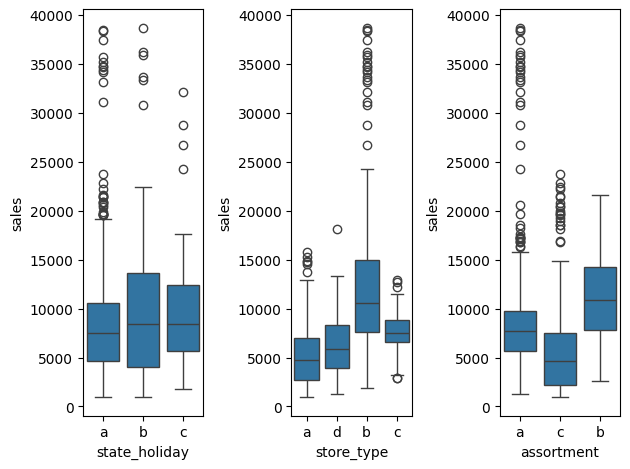

In [14]:
df_aux = df1[(df1['state_holiday'] != '0' ) & (df1['sales'] > 0 )]

plt.subplot( 1, 3, 1 )
sns.boxplot( x='state_holiday', y='sales', data=df_aux )

plt.subplot( 1, 3, 2 )
sns.boxplot( x='store_type', y='sales', data=df_aux )

plt.subplot( 1, 3, 3 )
sns.boxplot( x='assortment', y='sales', data=df_aux )

plt.tight_layout()

# 2.0. PASSO 02 - FEATURE ENGINEERING


In [15]:
df2 = df1.copy()

## 2.1. Mapa Mental de Hipóteses

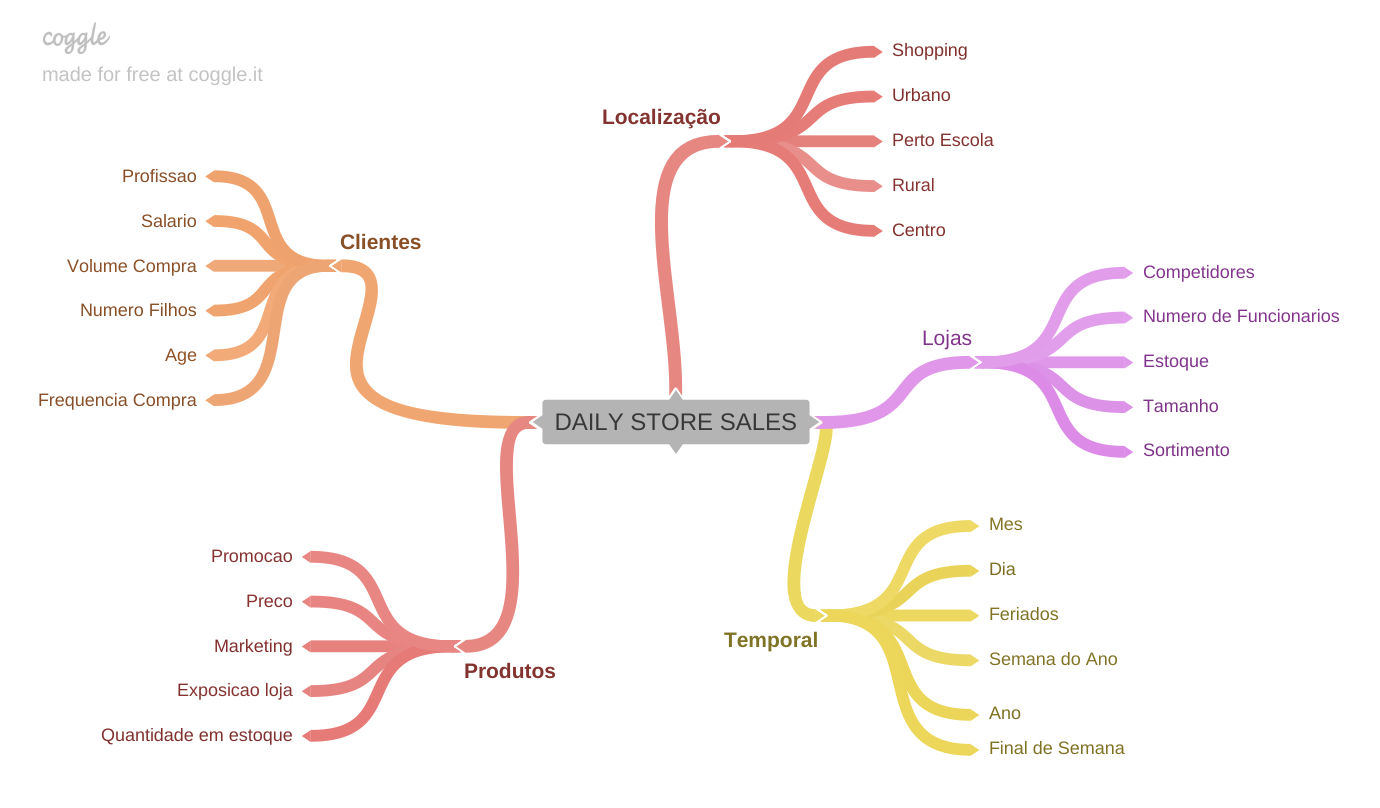

In [16]:
Image( 'img/MindMapHypothesis.png' )

## 2.2. Criação das Hipóteses

### 2.2.1. Hipoteses Loja


**1.** Lojas com número maior de funcionários deveriam vender mais.

**2.** Lojas com maior capacidade de estoque deveriam vender mais.

**3.** Lojas com maior porte deveriam vender mais.

**4.** Lojas com maior sortimentos deveriam vender mais.

**5.** Lojas com competidores mais próximos deveriam vender menos.

**6.** Lojas com competidores à mais tempo deveriam vendem mais.

### 2.2.2. Hipoteses Produto


**1.** Lojas que investem mais em Marketing deveriam vender mais.

**2.** Lojas com maior exposição de produto deveriam vender mais.

**3.** Lojas com produtos com preço menor deveriam vender mais.

**5.** Lojas com promoções mais agressivas ( descontos maiores ), deveriam vender mais.

**6.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**7.** Lojas com mais dias de promoção deveriam vender mais.

**8.** Lojas com mais promoções consecutivas deveriam vender mais.

### 2.2.3. Hipoteses Temporais ( Sazonalidade )


**1.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**2.** Lojas deveriam vender mais ao longo dos anos.

**3.** Lojas deveriam vender mais no segundo semestre do ano.

**4.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**5.** Lojas deveriam vender menos aos finais de semana.

**6.** Lojas deveriam vender menos durante os feriados escolares

## 2.3 Lista Final de Hipóteses

**1.** Lojas com maior sortimentos deveriam vender mais.

**2.** Lojas com competidores mais próximos deveriam vender menos.

**3.** Lojas com competidores à mais tempo deveriam vendem mais.

**4.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**5.** Lojas com mais dias de promoção deveriam vender mais.

**6.** Lojas com mais promoções consecutivas deveriam vender mais.

**7.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**8.** Lojas deveriam vender mais ao longo dos anos.

**9.** Lojas deveriam vender mais no segundo semestre do ano.

**10.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**11.** Lojas deveriam vender menos aos finais de semana.

**12.** Lojas deveriam vender menos durante os feriados escolares.


## 2.4. Feature Engineering

In [17]:
# year
df2['year'] = df2['date'].dt.year
# month
df2['month'] = df2['date'].dt.month
# day
df2['day'] = df2['date'].dt.day
# week of year
df2['week_of_year'] = df2['date'].dt.isocalendar().week
# year week
df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )

# competition since
df2['competition_since'] = df2.apply( lambda x: datetime.datetime( year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1 ), axis=1 )
df2['competition_time_month'] = ( ( df2['date'] - df2['competition_since'] )/30 ).apply( lambda x: x.days ).astype( int )

# promo since
df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )
df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w' ) - datetime.timedelta( days=7 ) )
df2['promo_time_week'] = ( ( df2['date'] - df2['promo_since'] )/7 ).apply( lambda x: x.days ).astype( int )

# assortment
df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended' )

# state holiday
df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day' )

In [18]:
df2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


# 3.0. PASSO 03 - FILTRAGEM DE VARIÁVEIS

In [19]:
df3 = df2.copy()

## 3.1. Filtragem das Linhas

In [20]:
df3 = df3[(df3['open'] != 0 ) & (df3['sales'] > 0 ) ]

## 3.2. Seleção das Colunas


In [21]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop( cols_drop, axis=1 )

# 4.0. PASSO 04 - ANÁLISE EXPLORATÓRIA DOS DADOS ( EDA )

In [22]:
df4 = df3.copy()

## 4.1. Análise Univariada

### 4.1.1. Response Variable

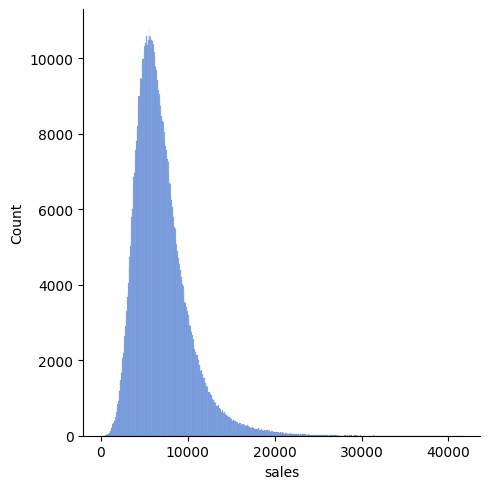

In [23]:
sns.displot(df4['sales'], kde=False, color='#6C9EFF')



### 4.1.2. Numerical Variable

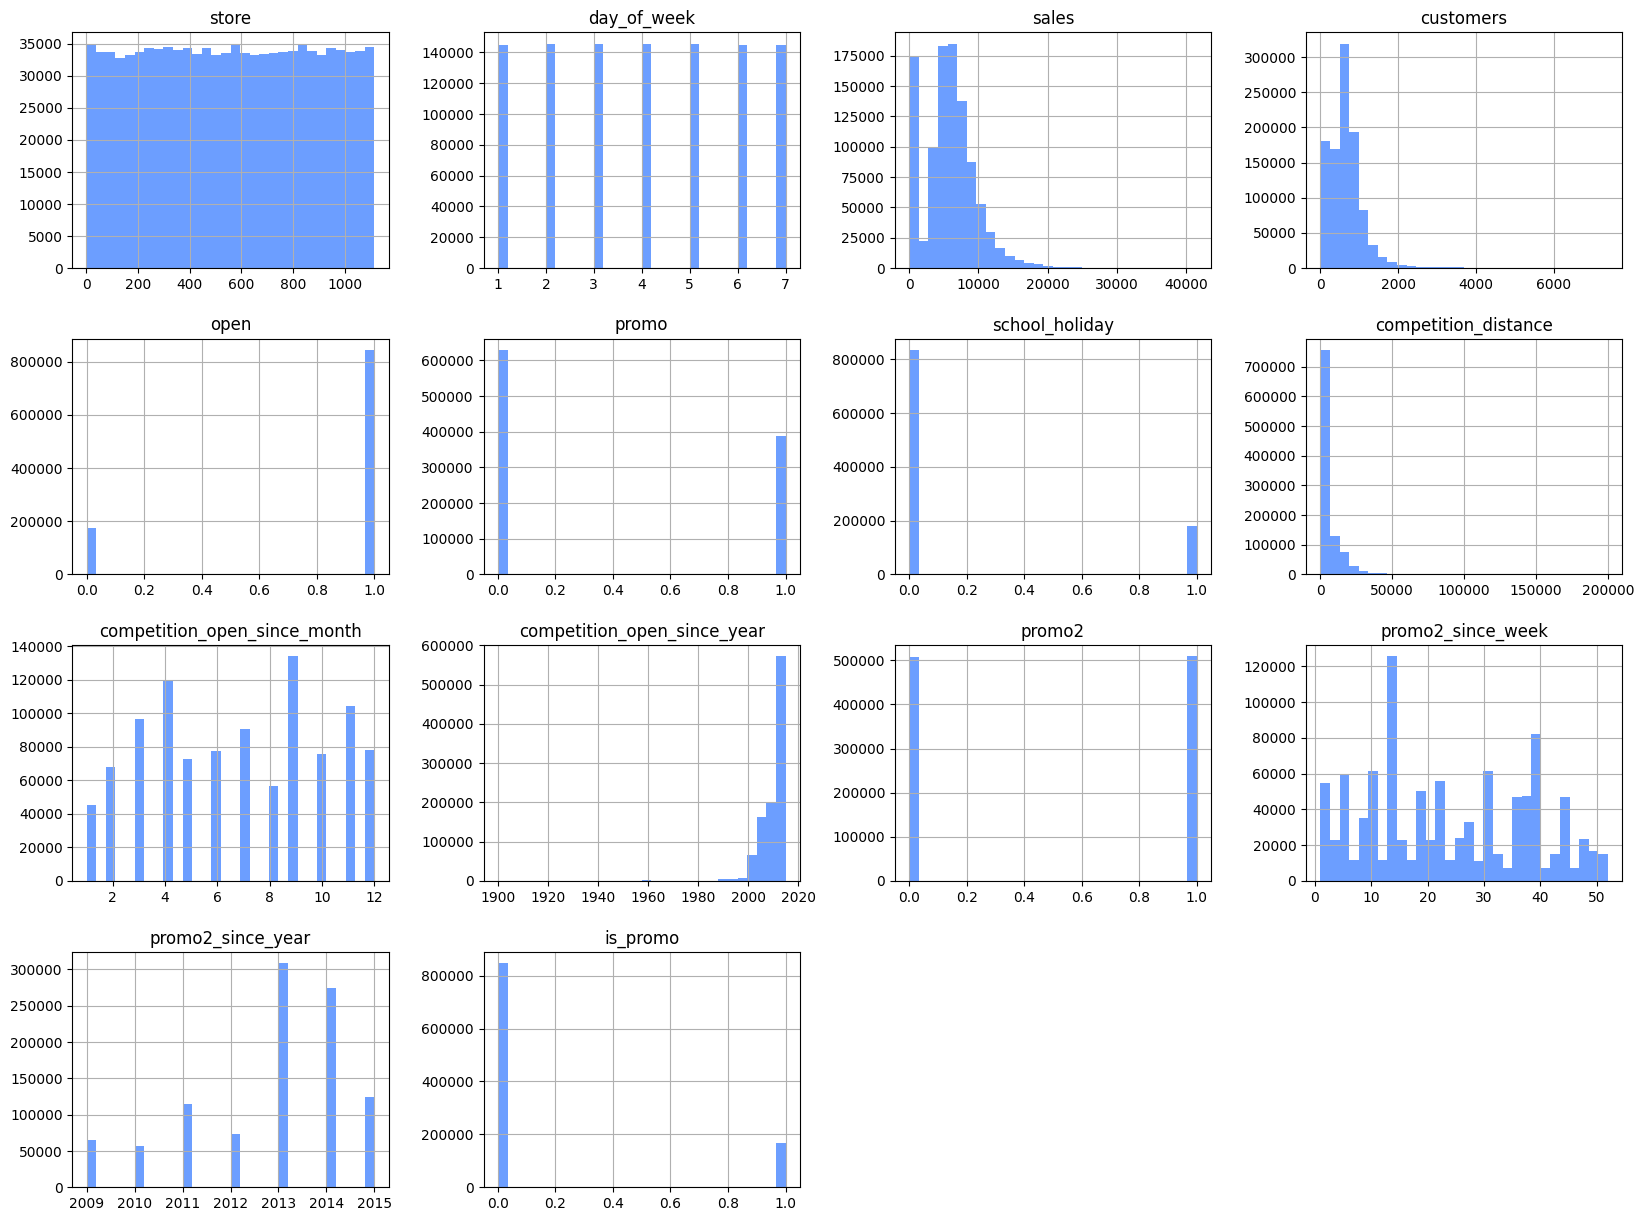

In [24]:
num_attributes.hist( bins=30, color='#6C9EFF', figsize=(20,15));


### 4.1.3. Categorical Variable

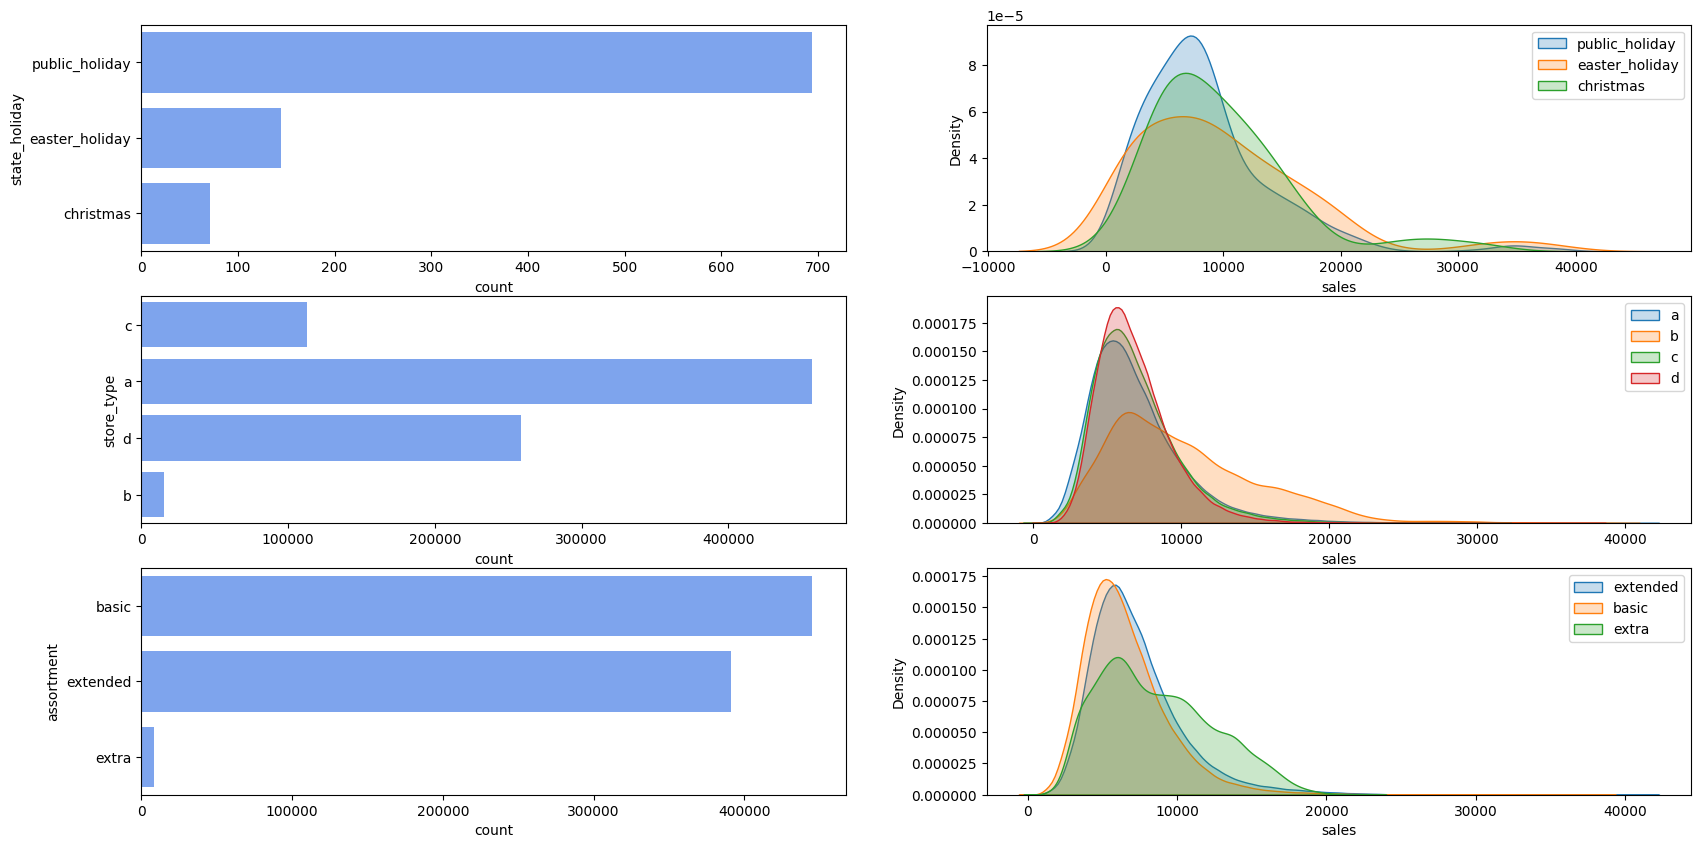

In [25]:
plt.figure(figsize=(20,10))

# state holiday
plt.subplot( 3, 2, 1)
aux = df4[df4['state_holiday'] != 'regular_day']
sns.countplot( aux['state_holiday'], color='#6C9EFF' )

plt.subplot( 3, 2, 2)
sns.kdeplot( df4[df4['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', fill=True )
sns.kdeplot( df4[df4['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', fill=True )
sns.kdeplot( df4[df4['state_holiday'] == 'christmas']['sales'], label='christmas', fill=True )
plt.legend()

# store type
plt.subplot( 3, 2, 3)
sns.countplot( df4['store_type'], color='#6C9EFF' )

plt.subplot( 3, 2, 4)
sns.kdeplot( df4[df4['store_type'] == 'a']['sales'], label='a', fill=True )
sns.kdeplot( df4[df4['store_type'] == 'b']['sales'], label='b', fill=True )
sns.kdeplot( df4[df4['store_type'] == 'c']['sales'], label='c', fill=True )
sns.kdeplot( df4[df4['store_type'] == 'd']['sales'], label='d', fill=True )
plt.legend()

# assortment
plt.subplot( 3, 2, 5)
sns.countplot( df4['assortment'], color='#6C9EFF' )

plt.subplot( 3, 2, 6)
sns.kdeplot( df4[df4['assortment'] == 'extended']['sales'], label='extended', fill=True )
sns.kdeplot( df4[df4['assortment'] == 'basic']['sales'], label='basic', fill=True )
sns.kdeplot( df4[df4['assortment'] == 'extra']['sales'], label='extra', fill=True )
plt.legend()


## 4.2. Análise Bivariada

### **H1.** Lojas com maior sortimentos deveriam vender mais.
**Hipótese Verdadeira.** As lojas com MAIOR sortimento, apresentam MAIOR média de Vendas.



Text(0.5, 1.0, 'Média de vendas por nível de sortimento ao longo das semanas do ano')

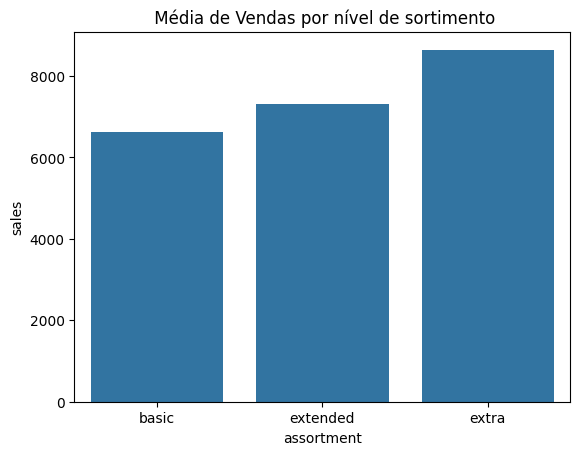

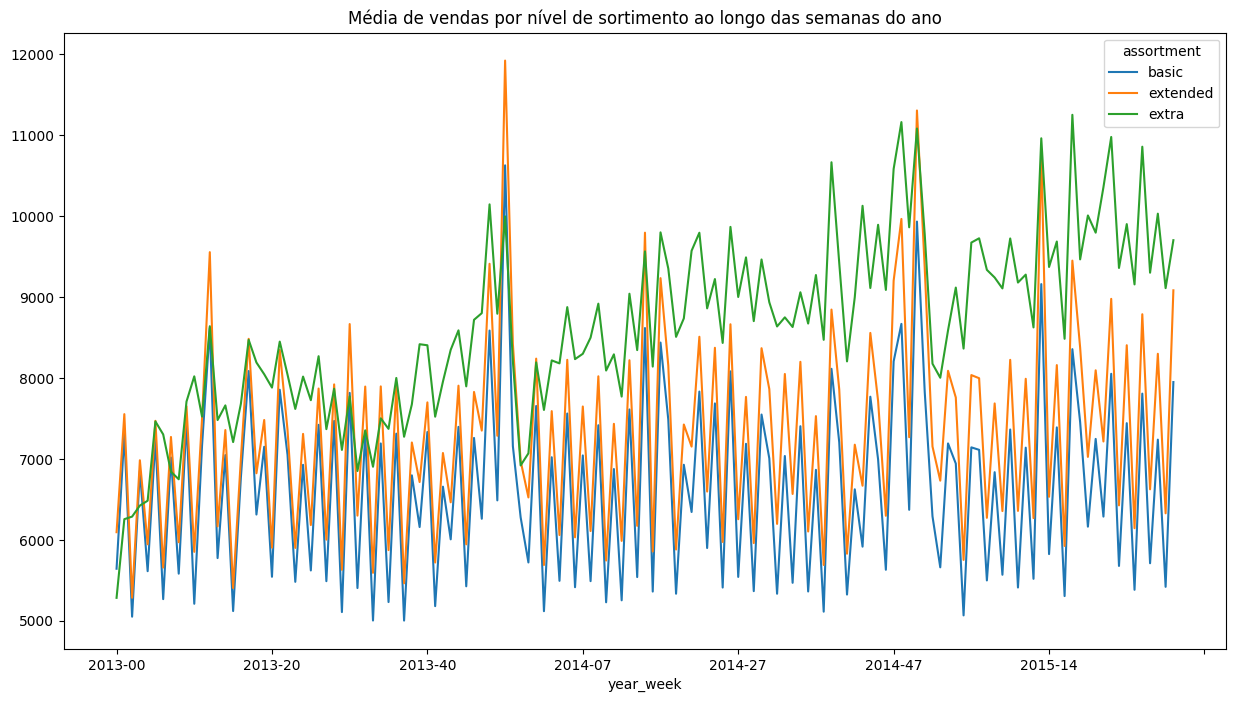

In [26]:
df_aux1 = df4[['assortment', 'sales']].groupby( 'assortment' ).mean().reset_index()
sns.barplot( x='assortment', y='sales', data=df_aux1 );
plt.title(' Média de Vendas por nível de sortimento')

df_aux2 = df4[['year_week', 'assortment', 'sales']].groupby( ['year_week', 'assortment'] ).mean().reset_index()
df_aux2.pivot( index='year_week', columns='assortment', values='sales' ).plot(figsize=(15,8))
plt.title('Média de vendas por nível de sortimento ao longo das semanas do ano')

In [27]:
df_aux2.head()

,year_week,assortment,sales
0,2013-00,basic,5642.277194
1,2013-00,extended,6094.001471
2,2013-00,extra,5282.431373
3,2013-01,basic,7307.459961
4,2013-01,extended,7553.623270


### **H2.** Lojas com competidores mais próximos deveriam vender menos.
**Hipótese Falsa** Lojas com competidores MAIS próximos vendem MAIS

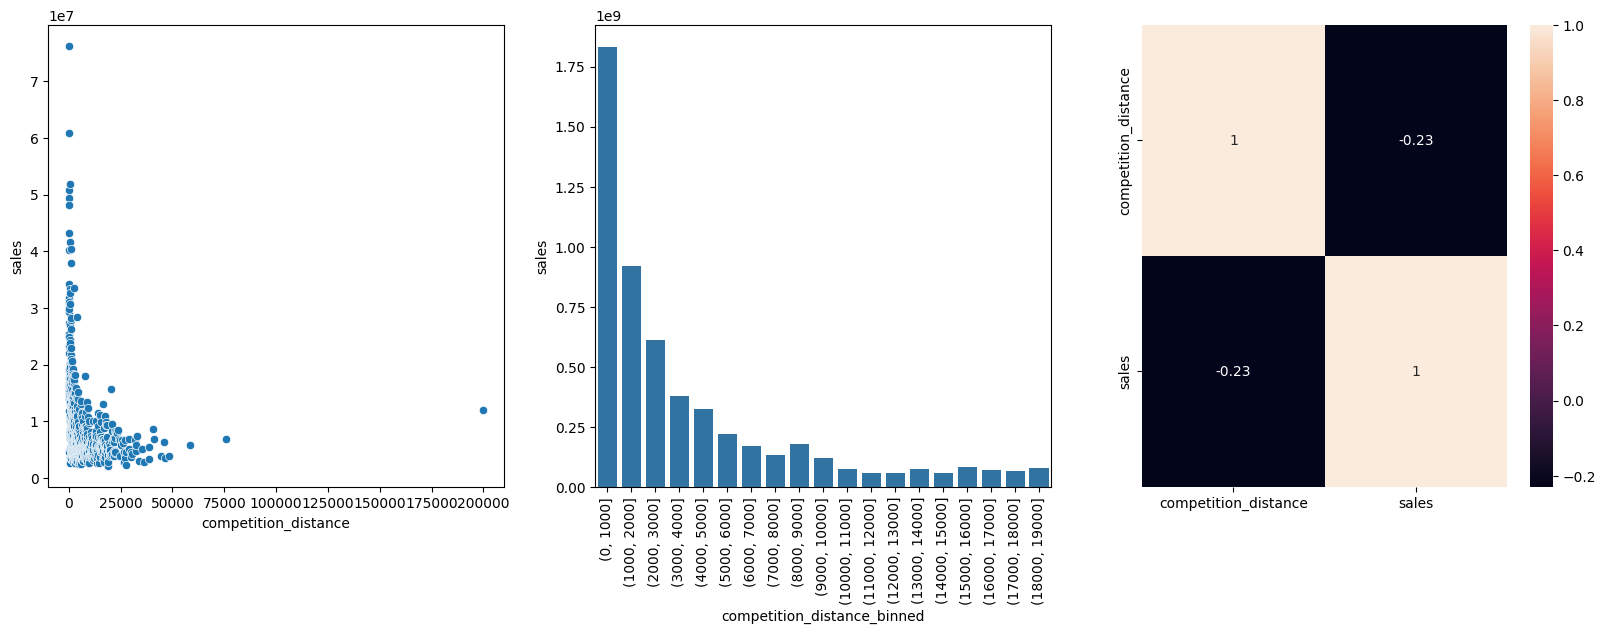

In [28]:
df_aux1 = df4[['competition_distance', 'sales']].groupby( 'competition_distance').sum().reset_index()

plt.figure( figsize=(20,6))
plt.subplot( 1, 3, 1 )
sns.scatterplot( x='competition_distance', y='sales', data=df_aux1 )

plt.subplot( 1, 3, 2 )
bins = list( np.arange( 0, 20000, 1000 ) )
df_aux1['competition_distance_binned'] = pd.cut(df_aux1['competition_distance'], bins = bins)
df_aux2 = df_aux1[['competition_distance_binned', 'sales']].groupby( 'competition_distance_binned').sum().reset_index()
sns.barplot( x='competition_distance_binned', y='sales', data=df_aux2);
plt.xticks( rotation=90 );

plt.subplot( 1, 3, 3 )
sns.heatmap( df_aux1[['competition_distance', 'sales']].corr( method='pearson' ), annot=True );

### **H3.** Lojas com competidores a mais tempo deveriam vendem mais.
**Hipótese Falsa.** Lojas com competidores há MAIS TEMPO vendem MENOS.

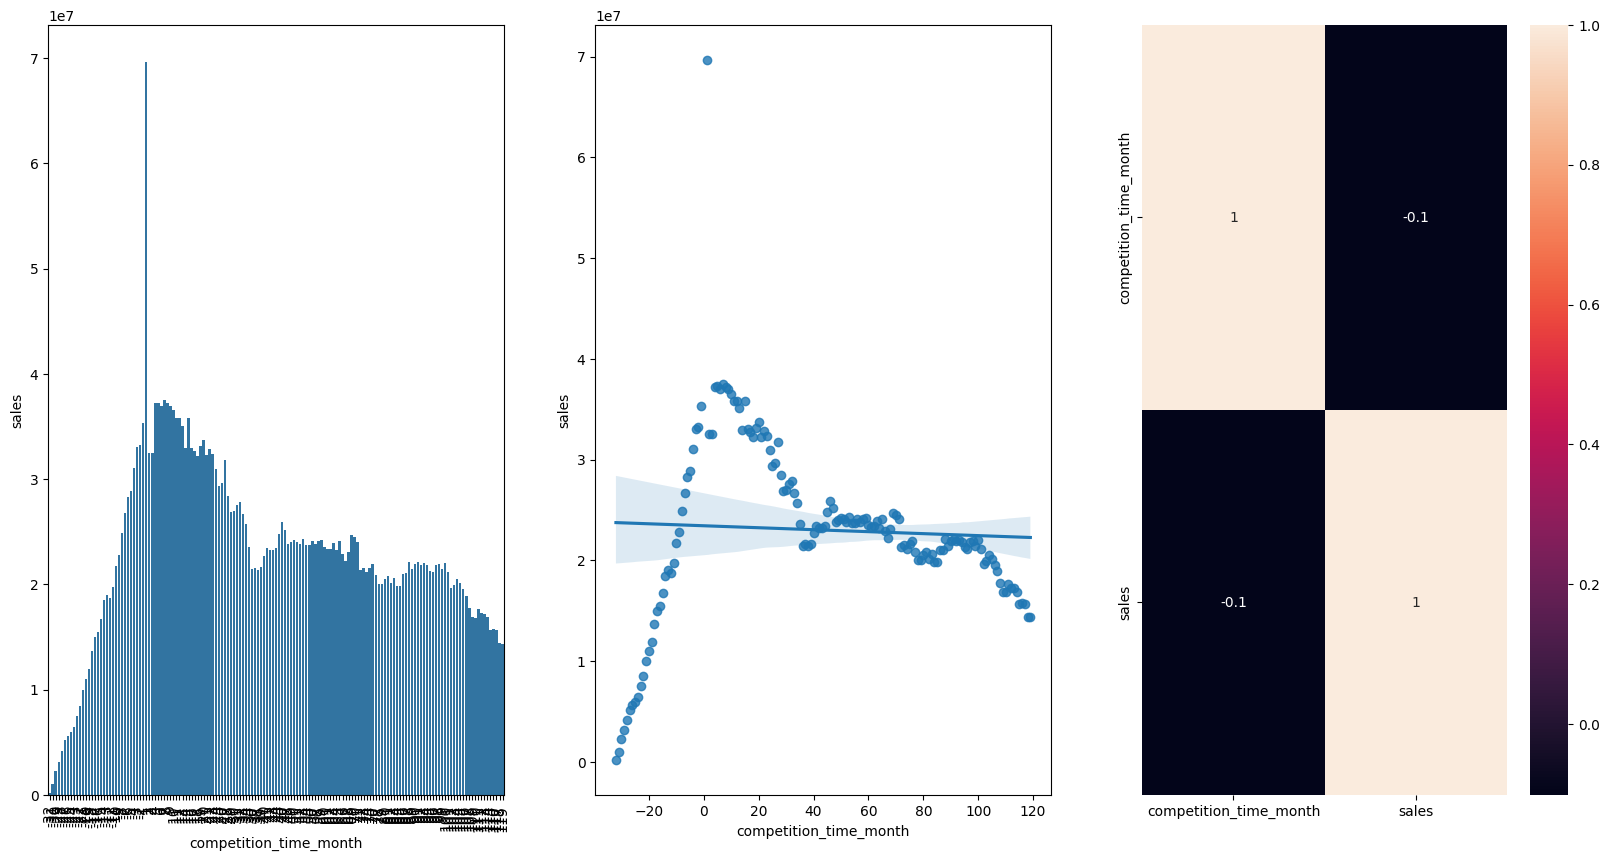

In [29]:
plt.figure(figsize=(20, 10))

plt.subplot( 1, 3, 1 )
df_aux1 = df4[['competition_time_month', 'sales']].groupby( 'competition_time_month' ).sum().reset_index()
df_aux2 = df_aux1[(df_aux1['competition_time_month'] < 120 ) & ( df_aux1['competition_time_month'] != 0 )]
sns.barplot( x='competition_time_month', y='sales', data=df_aux2 );
plt.xticks( rotation=90 );

plt.subplot( 1, 3, 2 )
sns.regplot( x='competition_time_month', y='sales', data=df_aux2 );

plt.subplot( 1, 3, 3 )
sns.heatmap( df_aux1.corr( method='pearson'), annot=True );


### **H4.** Lojas com promoções ativas por mais tempo deveriam vender mais.
**Hipótese Falsa.** Lojas com promoção contínua têm uma queda nas vendas depois de um certo período.




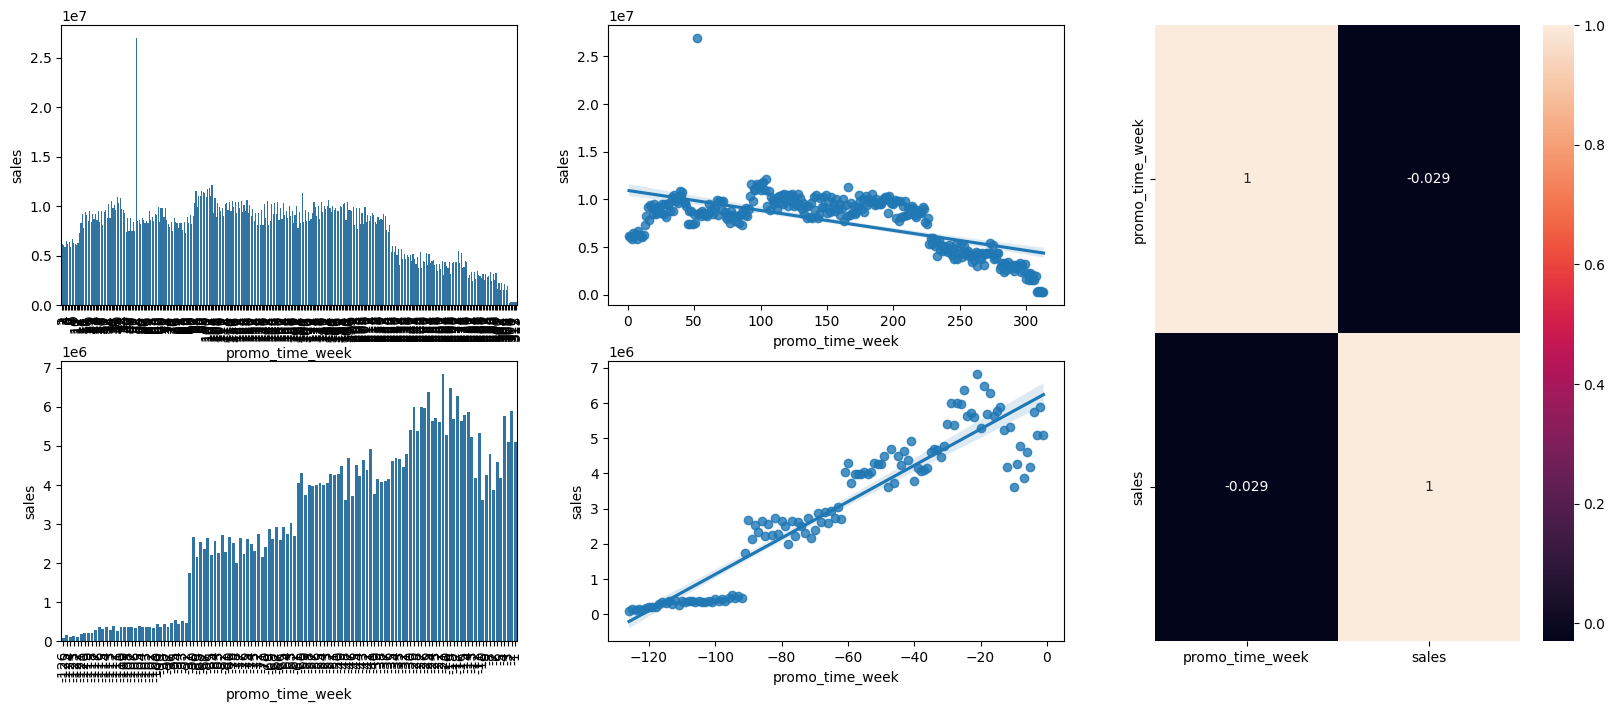

In [30]:
df_aux1 = df4[['promo_time_week', 'sales']].groupby( 'promo_time_week').sum().reset_index()
plt.figure(figsize=(20,8))

grid = GridSpec( 2, 3 )

plt.subplot( grid[0,0] )
df_aux2 = df_aux1[df_aux1['promo_time_week'] > 0] # Promoção estendida
sns.barplot( x='promo_time_week', y='sales', data=df_aux2)
plt.xticks( rotation=90 );

plt.subplot( grid[0,1] )
sns.regplot( x='promo_time_week', y='sales', data=df_aux2)

plt.subplot( grid[1,0] )
df_aux3 = df_aux1[df_aux1['promo_time_week'] < 0] # Promoção regular
sns.barplot( x='promo_time_week', y='sales', data=df_aux3)
plt.xticks( rotation=90 );

plt.subplot( grid[1,1] )
sns.regplot( x='promo_time_week', y='sales', data=df_aux3)

# correlação
plt.subplot( grid[:,2] )
sns.heatmap( df_aux1.corr( method='pearson' ), annot=True );




### <s>**H5.** Lojas com mais dias de promoção deveriam vender mais.</s>

### **H6.** Lojas com mais promoções consecutivas deveriam vender mais.
**Hipótese Falsa.** Lojas com mais promoções consecutivas vendem menos.

In [31]:
df4[['promo', 'promo2', 'sales']].groupby(['promo', 'promo2']).sum().sort_values(by='sales').reset_index()

,promo,promo2,sales
0,0,1,1289362241
1,1,1,1472275754
2,0,0,1482612096
3,1,0,1628930532


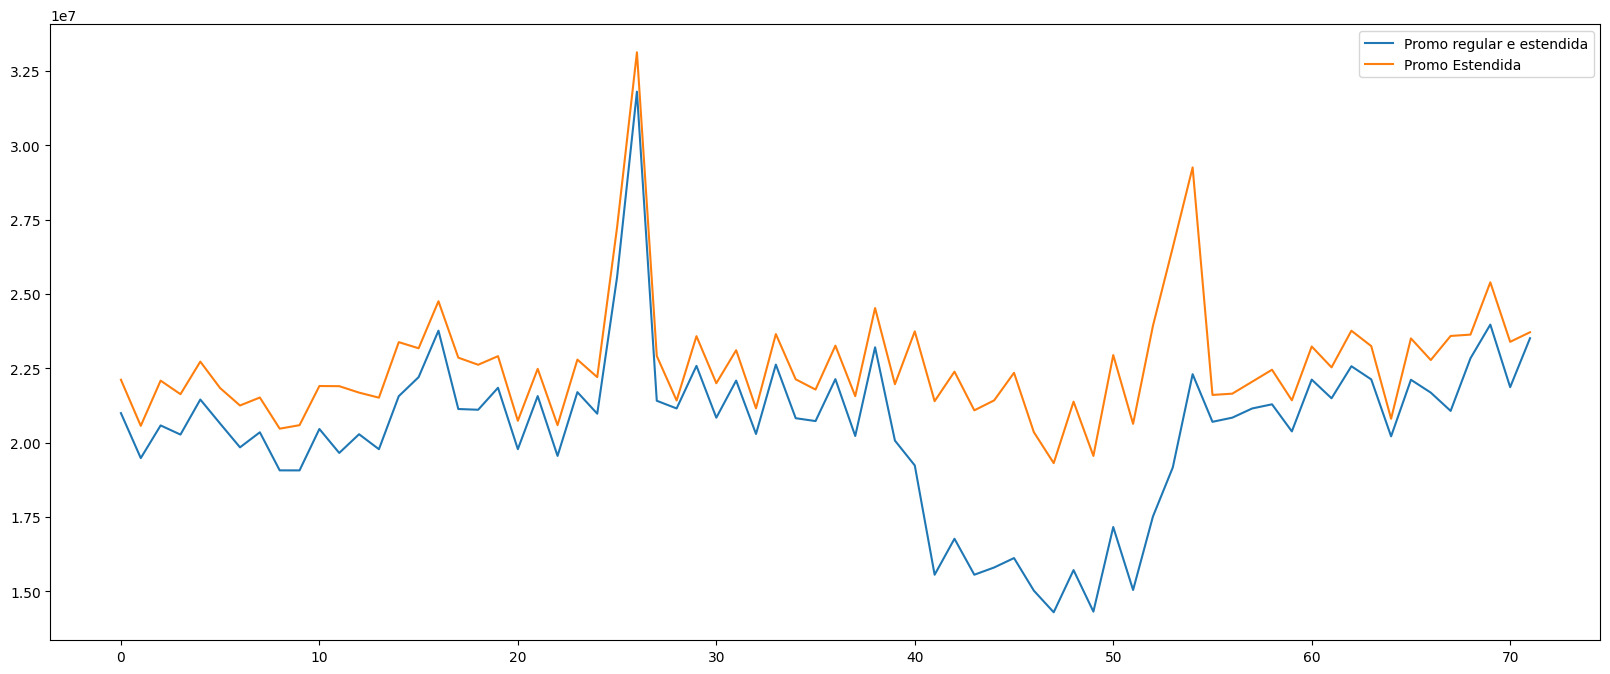

In [32]:

df_aux1 = df4[( df4['promo'] == 1) & ( df4['promo2'] == 1)][['year_week', 'sales']].groupby( 'year_week' ).sum().reset_index()
ax = df_aux1.plot(figsize=(20,8))

df_aux2 = df4[( df4['promo'] == 1) & ( df4['promo2'] == 0)][['year_week', 'sales']].groupby( 'year_week' ).sum().reset_index()
df_aux2.plot( figsize=(20,8), ax=ax )

ax.legend( labels=['Promo regular e estendida', 'Promo Estendida'])



### **H7.** Lojas abertas durante o feriado de Natal deveriam vender mais.
**Hipótese Falsa.** O total de vendas das lojas abertas durante o Natal é menor.

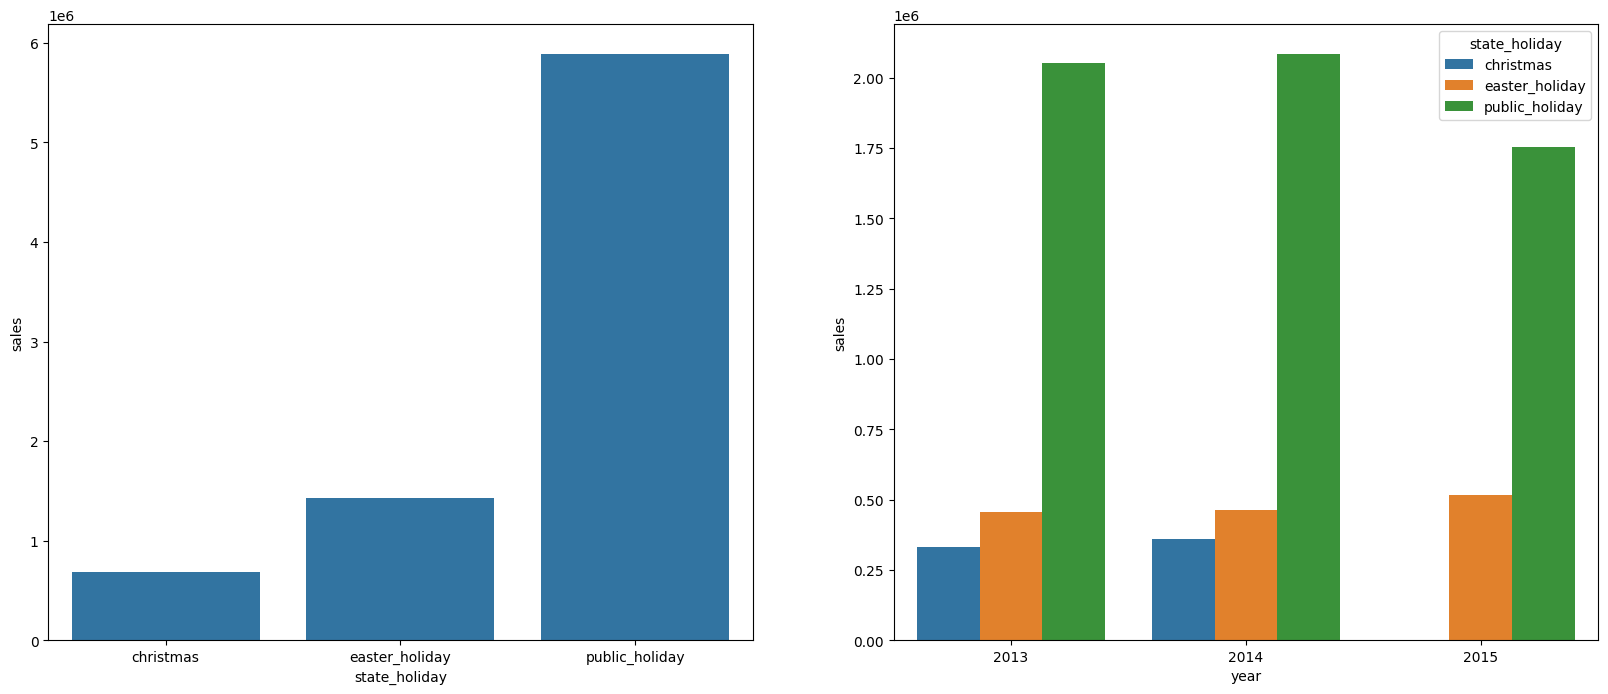

In [58]:
df_aux = df4[df4['state_holiday'] != 'regular_day']
plt.figure(figsize=(20,8))

plt.subplot( 1, 2, 1 )
df_aux1 = df_aux[['state_holiday', 'sales']].groupby( 'state_holiday' ).sum().reset_index()
sns.barplot( x='state_holiday', y='sales', data=df_aux1 );

plt.subplot( 1, 2, 2 )
df_aux2 = df_aux[['year', 'state_holiday', 'sales']].groupby( ['year', 'state_holiday'] ).sum().reset_index()
sns.barplot( x='year', y='sales', hue='state_holiday', data=df_aux2 );


### **H8.** Lojas deveriam vender mais ao longo dos anos.
**Hipótese Falsa.** Lojas vendem MENOS ao longo dos anos.

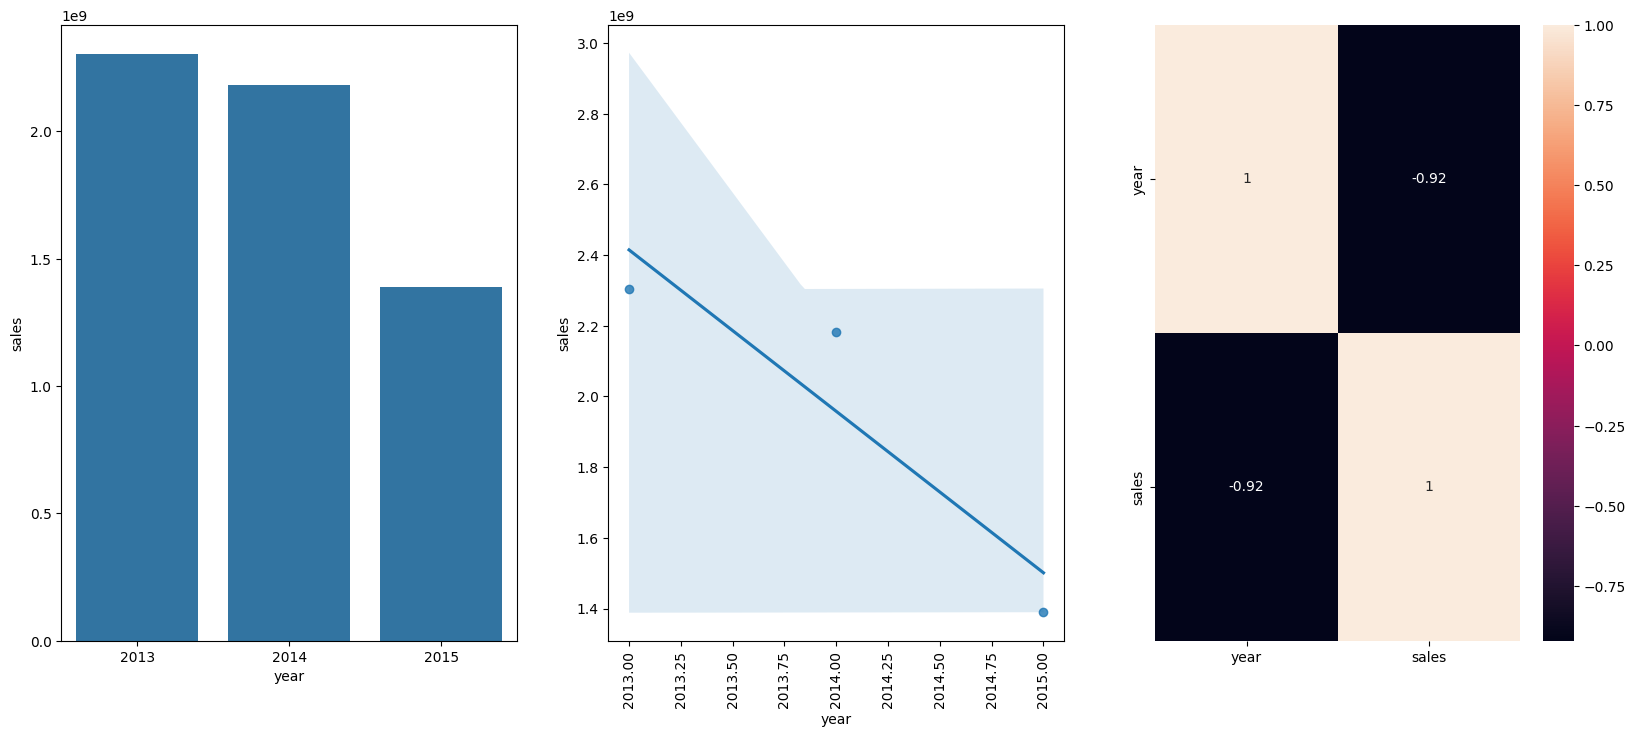

In [67]:
df_aux1 = df4[['year', 'sales']].groupby( 'year' ).sum().reset_index()
plt.figure(figsize=(20,8))

plt.subplot( 1, 3, 1 )
sns.barplot( x='year', y='sales', data=df_aux1 );

plt.subplot( 1, 3, 2 )
sns.regplot( x='year', y='sales', data=df_aux1 );
plt.xticks( rotation=90 )

plt.subplot( 1, 3, 3 )
sns.heatmap( df_aux1.corr( method='pearson' ), annot=True );

### **H9.** Lojas deveriam vender mais no segundo semestre do ano.
**Hipótese Falsa.** Lojas vendem MENOS no segundo semestre do ano.

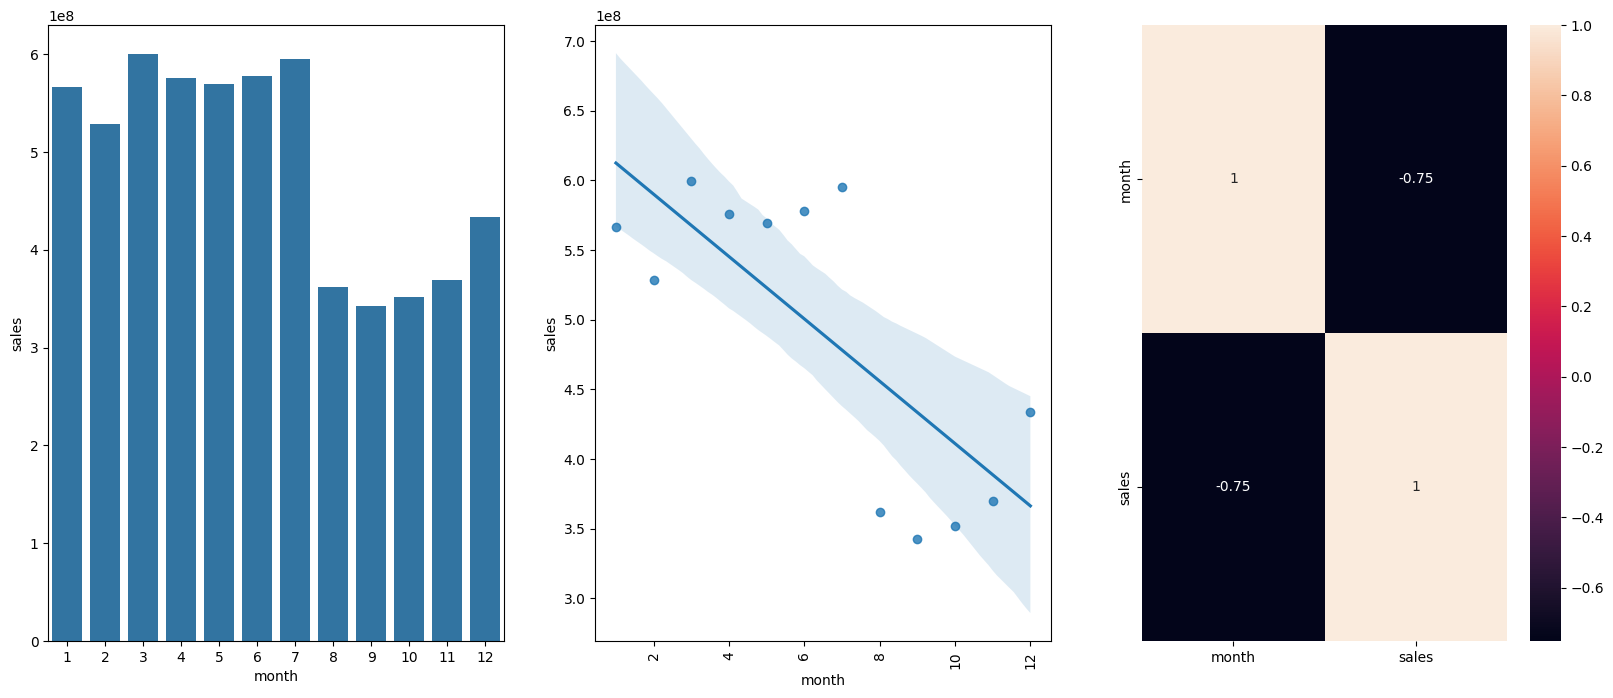

In [69]:
df_aux1 = df4[['month', 'sales']].groupby( 'month' ).sum().reset_index()
plt.figure(figsize=(20,8))

plt.subplot( 1, 3, 1 )
sns.barplot( x='month', y='sales', data=df_aux1 );

plt.subplot( 1, 3, 2 )
sns.regplot( x='month', y='sales', data=df_aux1 );
plt.xticks( rotation=90 )

plt.subplot( 1, 3, 3 )
sns.heatmap( df_aux1.corr( method='pearson' ), annot=True );

### **H10.** Lojas deveriam vender mais depois do dia 10 de cada mês.
**Hipótese Verdadeira**. Lojas vendem mais depois do dia 10 de cada mês.

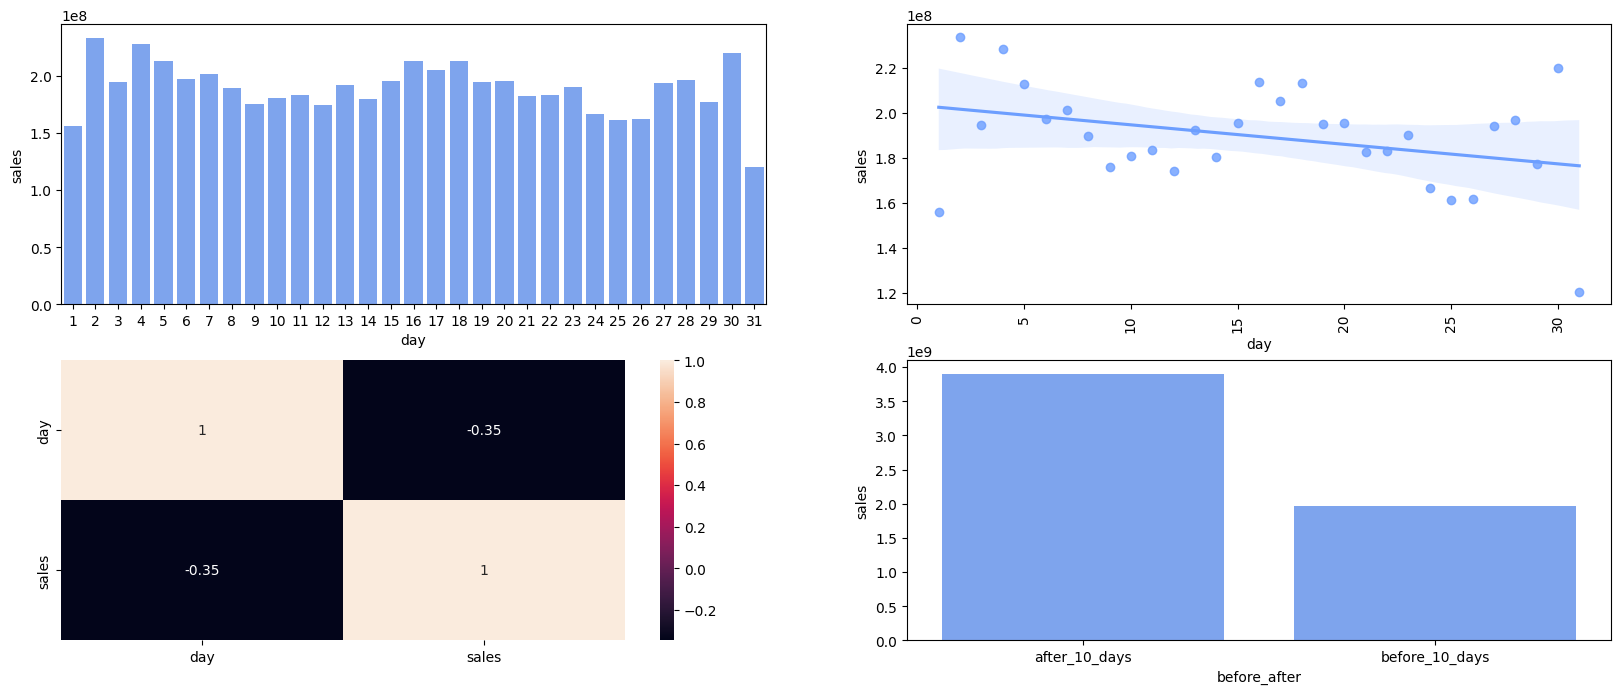

In [96]:
df_aux1 = df4[['day', 'sales']].groupby( 'day' ).sum().reset_index()
plt.figure(figsize=(20,8))

plt.subplot( 2, 2, 1 )
sns.barplot( x='day', y='sales', data=df_aux1, color='#6C9EFF' );

plt.subplot( 2, 2, 2 )
sns.regplot( x='day', y='sales', data=df_aux1, color='#6C9EFF' );
plt.xticks( rotation=90 )

plt.subplot( 2, 2, 3 )
sns.heatmap( df_aux1.corr( method='pearson' ), annot=True );


df_aux1['before_after'] = df_aux1['day'].apply( lambda x: 'before_10_days' if x <= 10 else 'after_10_days' )
df_aux2 = df_aux1[['before_after', 'sales']].groupby( 'before_after' ).sum().reset_index()

plt.subplot( 2, 2, 4 )
sns.barplot( x='before_after', y='sales', data=df_aux2, color='#6C9EFF' );


### **H11**. Lojas deveriam vender menos aos finais de semana.
**Hipótese Verdadeira.** Lojas vendem MENOS aos finais de semana.

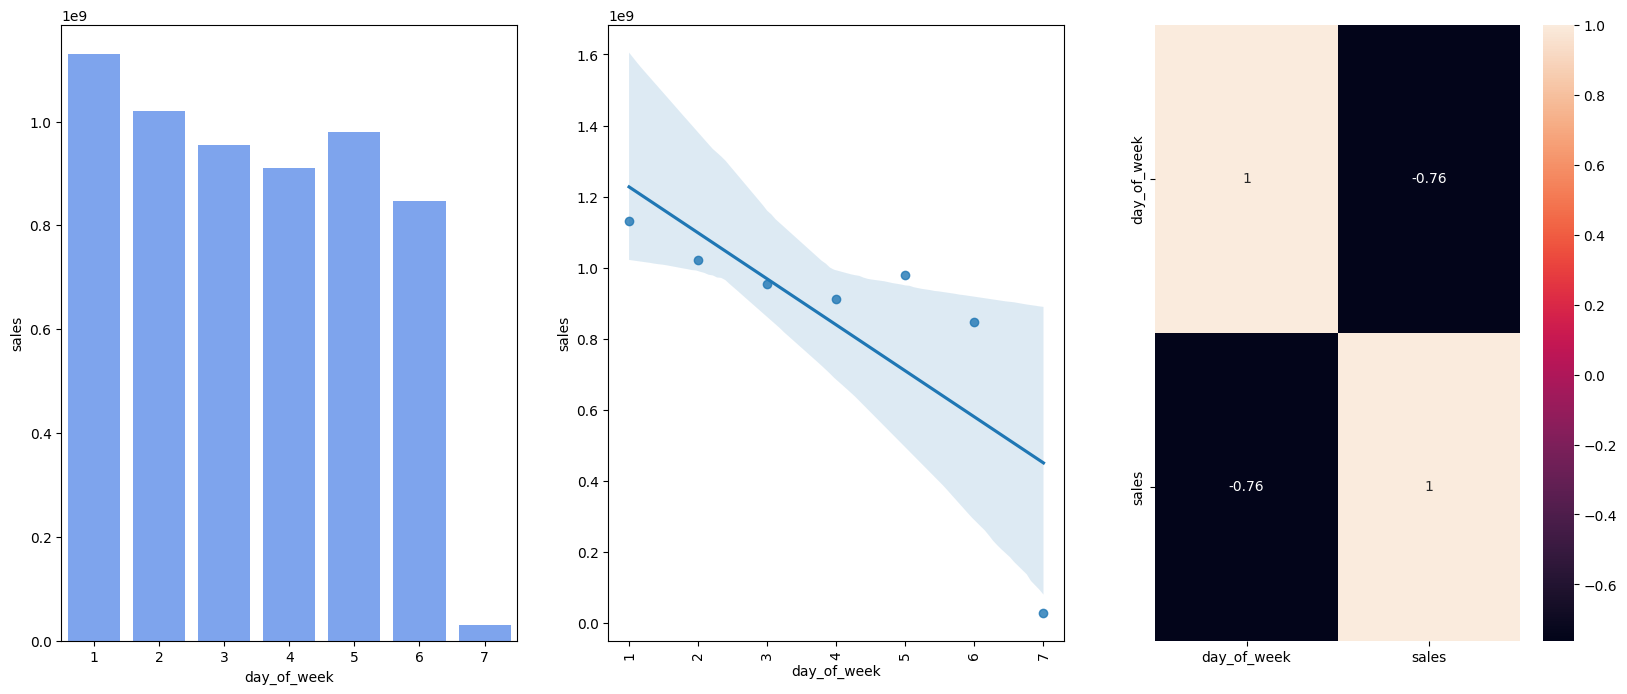

In [120]:
df_aux1 = df4[['day_of_week', 'sales']].groupby( 'day_of_week' ).sum().reset_index()
plt.figure(figsize=(20,8))

plt.subplot( 1, 3, 1 )
sns.barplot( x='day_of_week', y='sales', data=df_aux1, color='#6C9EFF' );

plt.subplot( 1, 3, 2 )
sns.regplot( x='day_of_week', y='sales', data=df_aux1 );
plt.xticks( rotation=90 )

plt.subplot( 1, 3, 3 )
sns.heatmap( df_aux1.corr( method='pearson' ), annot=True );

### **H12.** Lojas deveriam vender menos durante os feriados escolares.
**Hipótese Verdadeira.** Lojas vendem menos durante os feriados escolares, exceto os meses de Julho e Agosto.

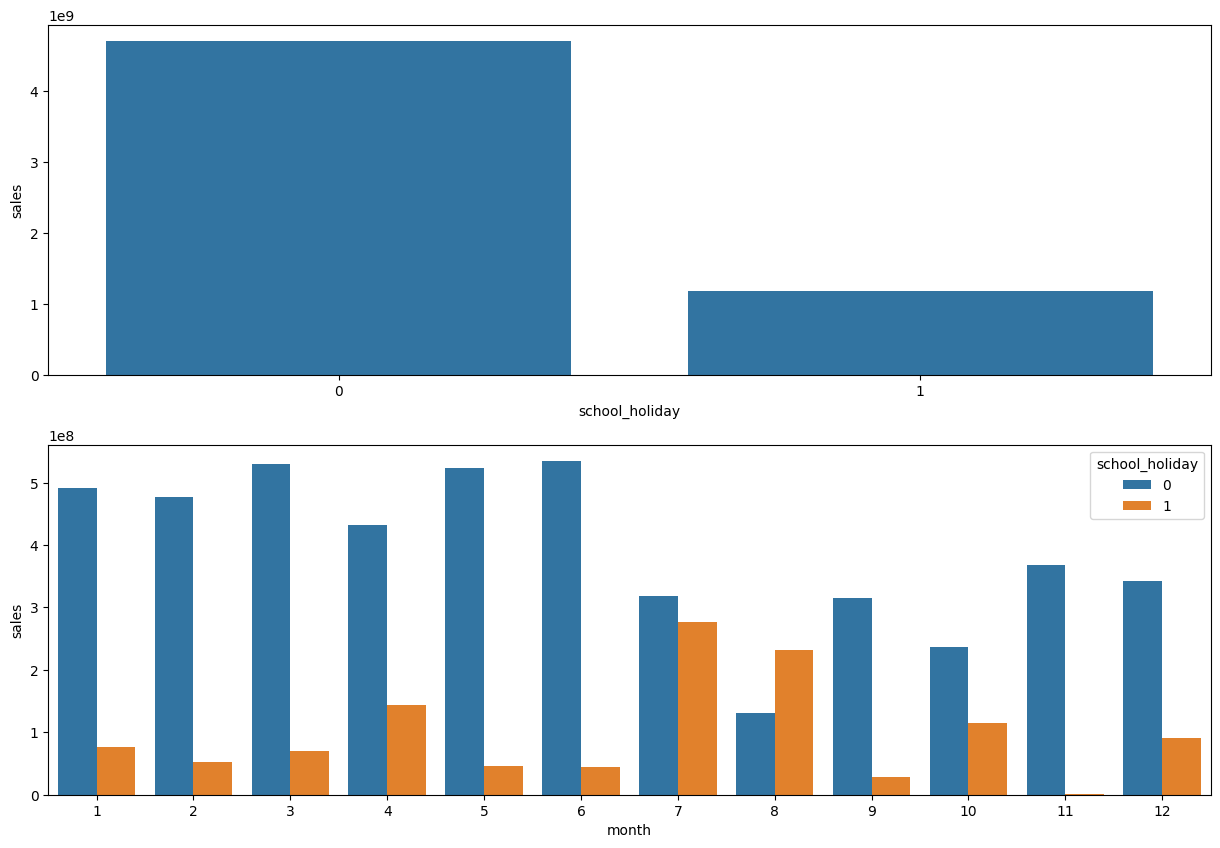

In [124]:
plt.figure(figsize=(15,10))
df_aux1 = df4[['school_holiday', 'sales']].groupby( 'school_holiday' ).sum().reset_index()

plt.subplot( 2, 1, 1 )
sns.barplot( x='school_holiday', y='sales', data=df_aux1 );

plt.subplot( 2, 1, 2 )
df_aux2 = df4[['month', 'school_holiday', 'sales']].groupby( ['month', 'school_holiday'] ).sum().reset_index()
sns.barplot( x='month', y='sales', hue='school_holiday', data=df_aux2 );

## 4.3. Análise Multivariada